In [520]:
%matplotlib inline
import numpy as np
from numpy.random import randint, rand
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from tqdm import tqdm
import pandas as pd
import imageio
from IPython.display import Image
from scipy.stats import norm

def gif(filenames, name):
    with imageio.get_writer(name, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def normalize(x):
    return x/abs(np.max(x))

# Price dynamics in the Ising universality class

## Rapid intro

The [Ising model](https://en.wikipedia.org/wiki/Ising_model) of statistical mechanics is a beautifully simple model built on the energetic tension between order and disorder. It is captured by the Hamiltonian (total energy functional)
$$
H_{Ising}(s) = -J\sum_{i,j\in \Lambda, \|i-j\|=1}s_is_j -h\sum_{i∈ \Lambda}s_i
$$
where $J,h>0$ and $\Lambda$ a graph (we take the graph to be $\mathbb Z^2$). The variable $s_i$, referred to as spin, is simply a binary valued parameter. The state of a set of spins on graph $\Lambda$ is simply the configuration $\mathcal H_t:=\{s_i\}_{i∈ \Lambda}$ at time (step) $t$. For our purposes (and for the physical model as well) we take $s_i\in\{-1, 1\}$ and we compactify $\mathbb Z^2$ to the discrete 2-torus. Then, skipping an enormous amount of statistical physics, we declare
$$
μ(s) := \frac{e^{-H(s)\beta}}{\sum_s e^{-β H(s)}}
$$
to be a (Gibbs) measure on the configuration space of spins, $\mathcal H_t$ (\*) with $\beta$ is the inverse temperature. If we know what this measure is, we have *soved* the model because we can determine all the correlators. Famously, for $h>0$ and $\Lambda=\mathbb Z^d$, $d>1$ this model has yet to be solved exactly. A particularly important property of the system is the so-called magnetization, $M(t):=\sum_{i∈ \mathcal H_t}s_i$, the average magnetization in equilibrium, $\langle M\rangle = ∫ d\mu(s) s $ and the coarse grained magnetization, $\bar M_w(t)=\sum_{t∈ [t-w, t)}M(t)/w$. As one sweeps $\beta$, the system undergoes an order-disorder transition. When the system is *cold*, the total energy is minimized by a global alignment of spins (this is the ferromagnetic phase). As temperature is increased, thermal fluctuations destroy this order. Beyond a critical temperature (called the Curie temperature), it is energetically favorable to assume a disordered configuration of spins. 


>(\*) We can be very abstract here. We have some measure on the configuration space of spins. To this we can associate a Markov generator
$$
\sum_{i\in\Lambda}\mathcal J_i[\mu(s)]dE_j(s)
$$
where $\mathcal J_i[\mu(s)]$ is any jump process that is reversible wrt the Gibbs measure (this is something called detailed balance the Monte Carlo algorithm also has to obey). The functions $dE_j:\mathcal H_t\to \mathbb R$ encode, in some fashion, the cost of flipping spin $j\in\Lambda$. The resulting Markov process is a sequence of spin configurations, $s(t≥ 0)$ from which we can extract the coarse-grained magnetization as explained above. See [[1]](https://cims.nyu.edu/~jcm777/Ising.pdf).

Suppose we know no physics but would like to describe the dynamics of the price of a particular asset. The simplest interesting model would capture the tension between an agent positioning themselves in alignment with their semi-local consensus position (what their neighbours are doing) and an agent being a contrarian and taking a position against the consensus if they deem it optimal depending on the information available. The reliance on the actions of neighbouring agents is encoded in the cost/risk functional
$$
\mathcal C_{consensus}=-J\sum_{i,j\in \Lambda, \|i-j\|=1}s_is_j
$$
with the spin variables now denoting directions of trades placed by the agent at a time step. The positive constant $J$ sets a scale for the prevalence of herding behaviour in the dynamics. Breaking from the consensus has an associated cost with a dynamical element to it
$$
\mathcal C_{contrarian} = -h|M(t)|\sum_{i\in\Lambda} s_i.
$$
The agent will take a position against a semilocal consensus based on current market sentiment (this is the $|M(t)|$). Notice that this is different from the vanilla Ising model but poses no additional difficulty in computing correlators. The Hamiltonian-equivalent functional for describing price dynamics is then
$$
\mathcal C =\mathcal C_{consensus}+\mathcal C_{contrarian}.
$$
This model also has an ordered and a disordered phase. We are interested in the disordered phase since a global buy or sell position (eventually) respectively drives the price to $\infty$ or $0$. 

We are missing an important element in the model - we have no idea if the decimation of $t∈ [0, T])$ into discrete trading steps reflects the timescale of interest. In order to set such a scale, we need a coarse-graining parameter. There are two natural choices, one of which is using the moving average magnetization (market sentiment), $\bar M_w(t)$, from which one can compute a normalized price process, $P_w(t)=\frac{\exp\bar M_w(t)}{\mathcal N}$. Another is simply to construct a normalized return sequence
$$
dM_w(t) = \frac{M(t)-M(t-w)}{\mathcal N}.
$$

See [[2]](https://www.sciencedirect.com/science/article/abs/pii/S0378437117303916) for a basic example and references therein for the kinds of things people do along these lines. Though very short and mostly focused on scaling behavior (which I won't talk much about) [[3]](https://www.nature.com/articles/17290) is a much better paper.

## Monte Carlo simulation

My side note above translates pretty clearly into a general Monte Carlo algorithm for describing the evolution of market states. Beside the technicality of detailed balance, the idea is very simple: With each step, flip a random spin and accept the move if the flip lowers the total cost (else, accept based on the Boltzmann distribution). Here is a walkthrough of the algorithm for the case of $h=0$ (just for simplicity)

1. Initialize a random array of spins

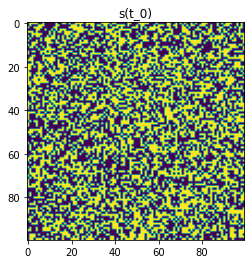

In [486]:
def initialize(N):
    return 2*randint(2, size=(N,N))-1

plt.title(r"s(t_0)")
plt.imshow(initialize(100));

2. Flip a random position, accept the move if it lowers total cost or if $e^{-β \Delta C_i(t_j)}>x$ with $x∼ \text{Uniform}(0,1)$ (this is the reversible wrt Gibbs measure business - see [[detailed balance]](https://en.wikipedia.org/wiki/Detailed_balance))

In [487]:
def step(state, beta):
    N = len(state)
    for i in range(0, N):
        for j in range(0, N):
            x, y = randint(0, N), randint(0, N)
            nn = state[(x+1)%N, y]+state[(x-1)%N, y]+state[x, (y+1)%N]+state[x, (y-1)%N]
            dc = 2*state[x, y]*nn
            if dc<0 or rand()<np.exp(-beta*dc):
                state[x, y] *= -1
            else:
                pass
    return state

3. Repeat for each time step. Compute and store magnetization (empirical mean of the state)

Text(0, 0.5, '$M(t)$')

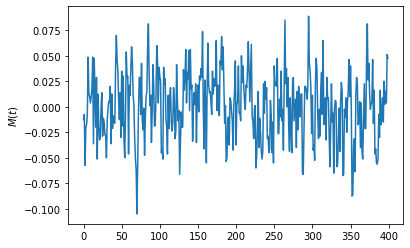

In [489]:
def run(init_state, n_samples, beta):
    states = [init_state]
    magnetization = np.zeros(n_samples)
    f_names = []
    for i in range(0, n_samples):
        state = step(states[-1], beta)
        states.append(state)
        magnetization[i] = state.mean()
#         Rest of the code is generate and display gif
#         plt.imshow(state)
#         plt.savefig("runs/state_frame"+str(i)+".png")
#         plt.close()
#         f_names.append("runs/state_frame"+str(i)+".png")
#     gif(f_names, "MC_steps_ordered.gif")
    return magnetization
    

magnetization = run(initialize(40), 400, .1)
plt.figure()
plt.plot(magnetization);
plt.ylabel(r"$M(t)$")
# Image(url='MC_steps.gif') 

$\beta$, the inverse temperature, is the scale of random fluctuations. In our model, it can be understood as a proxy for volatility. Compare for instance the behavior of the agents first for a *cool* market vs a *hot* one:

Hot | Cold
- | - 
![$β =0.2$](MC_steps_hot.gif) | ![$β =0.6$](MC_steps_cold.gif)

Of course, if we cool things down enough we will eventually have the consensus totally dominate (because $h=0$) which is not very interesting as discussed previously.

## Full featured implementation


In [469]:
def dist(i, j):
    return np.sqrt(i**2+j**2)

def shift(arr, num, fill_value=0):
    # https://www.delftstack.com/howto/numpy/python-numpy-shift-array/
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def autocorr(x, lag):
    lag = int(lag)
    return np.corrcoef(np.array([x[:-lag], x[lag:]]))

class MC_ising:
    def __init__(self, N, J=1, h=1, n_samples=500):
        self.state = 2*randint(2, size=(N,N))-1
        self.n = len(self.state)
        self.N = N
        self.mag = self.state.sum()
        self.J = J
        self.n_samples = n_samples
        self.h = h
        
    def nn(self, i, j):
        return self.state[(i+1)%self.N, j]+self.state[(i-1)%self.N, j]+self.state[i, (j+1)%self.N]+self.state[i, (j-1)%self.N]
    
    def nn_nonlocal(self, i, j): # Ignore - I was just playing around (trying to get a Levy return distribution)
        nnn = 0
        for ii in range(-int(self.N/2), int(self.N/2)):
            for jj in range(-int(self.N/2), int(self.N/2)):
                if (i-ii)%self.N==(j-jj)%self.N:
                    pass
                else:
                    nnn += (self.state[(i+ii)%self.N, (j+jj)%self.N])/dist((i-ii)%self.N, (j-jj)%self.N)**(2+1/3)
        return nnn
        
    def step(self, beta_idx):
        self.mag = self.state.sum()
        for i in range(0, self.n):
            for j in range(0, self.n):
                x, y = randint(0, self.N), randint(0, self.N)
                dE = 2*self.J*self.state[x, y]*self.nn(x, y)+2*self.state[x, y]*self.h*abs(self.mag)/(self.N**2*self.n_samples)
                if dE < 0 or rand()<np.exp(-self.beta[beta_idx]*dE):
                    self.state[x, y] *= -1
        self.mag = self.state.sum()
        
    def run(self, beta, n_therm=200, verbose=True, save_states=False, gif_name=None):
        self.beta = beta
        n_beta = len(beta)
        if n_beta ==1:
            beta_flag = True # turn on MC progress bar
            n_therm = 1 # no need to wait for thermalization if there is only one temp
        else:
            beta_flag = False
#         self.energies = np.zeros(n_beta)
        self.magnetizations = np.zeros(n_beta)
        self.filenames = [] # For creating gifs
        self.mag_mat = np.zeros([n_beta, self.n_samples])
        if verbose:
            print("Running MC on "+str(self.N)+"x"+str(self.N)+" square lattice")
            if n_beta == 1:
                print("Inverse temperature: ", self.beta[0])
            else:
                print("Number of time/temperature steps: ", n_beta)
            print("Number of MC samples: ", self.n_samples)
            print("Thermalization steps: ", n_therm)
            print("J: ", self.J, "/kB")
            print("h: ", self.h, "/kB")
        for b_idx in tqdm(range(0, n_beta), disable=beta_flag):
            en = 0
            mag_ = 0
            for therm_idx in range(0, n_therm):
                self.step(b_idx)
            for mc_idx in tqdm(range(0, self.n_samples), disable=not beta_flag):
                self.step(b_idx)
#                 en += self.energy()
                mag_ += self.mag
                self.mag_mat[b_idx, mc_idx] = self.mag
                if save_states:
                    plt.imshow(self.state)
                    plt.savefig("runs/state_frame"+str(mc_idx)+".png")
                    plt.close()
                    self.filenames.append("runs/state_frame"+str(mc_idx)+".png")
#             self.energies[b_idx] = en/(self.N**2*self.n_samples)
            self.magnetizations[b_idx] = mag_/(self.N**2*self.n_samples)
            if save_states:
                gif(self.filenames, str(self.beta[b_idx])+"_"+gif_name)
                
    def get_returns_mat(self, lag):
        self.returns_mat = (self.mag_mat[:, :]-shift(self.mag_mat[:, :], -lag))
        return self.returns_mat
        
    def plot(self, lag1, lag2, y_lims=(-0.15, 0.15)):
        lag = lag1
        if len(self.beta)==1:
            b_idx = 0
            returns = (self.mag_mat[b_idx, :]-shift(self.mag_mat[b_idx, :], -lag))#/np.roll(ising.mag_mat[b_idx, :], -lag)
            returns = returns[2:-lag]/np.max(returns)
            price = np.exp(moving_average(self.mag_mat[b_idx, :], lag2))
            (mu, sigma) = norm.fit(returns)

            plt.figure(figsize=(20,5))
            plt.title("Returns with {0} step lag".format(lag))
            plt.stem(returns, markerfmt=" ")
            plt.figure(figsize=(20,5))
            plt.ylabel(r"$P_w(t)$")
            plt.title("Price with {0} step window".format(lag2))
            plt.plot(price/np.max(price))
            plt.figure(figsize=(20,5))
            pd.plotting.autocorrelation_plot(pd.Series(returns))
            plt.ylim(*y_lims)
            plt.figure()
            plt.title("Returns distribution")
            n, bins, patches = plt.hist(returns, density=True, bins=25, alpha=0.6)
            y = norm.pdf( bins, mu, sigma)
            plt.plot(bins, y, 'r--', linewidth=2)
            self.returns = returns
            self.price = price
        else:
            plt.plot(self.beta, np.abs(self.magnetizations), '.', label=r"$M(t)$")
            plt.plot(self.beta[1:], np.diff(self.magnetizations), '.-', label=r"$dM(\beta)$")
            plt.legend()
            print("Critical 1/T: ", round(self.beta[np.argmax(np.diff(self.magnetizations))], 4))
# ising.mag_mat[b_idx, :]

In [451]:
ising = MC_ising(10, n_samples=10000, h=2)
ising.run([.01],  n_therm=1)

Running MC on 10x10 square lattice
Inverse temperature:  0.01
Number of MC samples:  10000
Thermalization steps:  1
J:  1 /kB
h:  2 /kB


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 565.52it/s]


One of the outputs of the simulation is a matrix of magnetizations, $M(\beta, t_n)$. Using this, we can compute $r_w(t)$ and $P_w(t)$ as indicated in the introduction. The two $w$ parameters will be tweaked independently. 

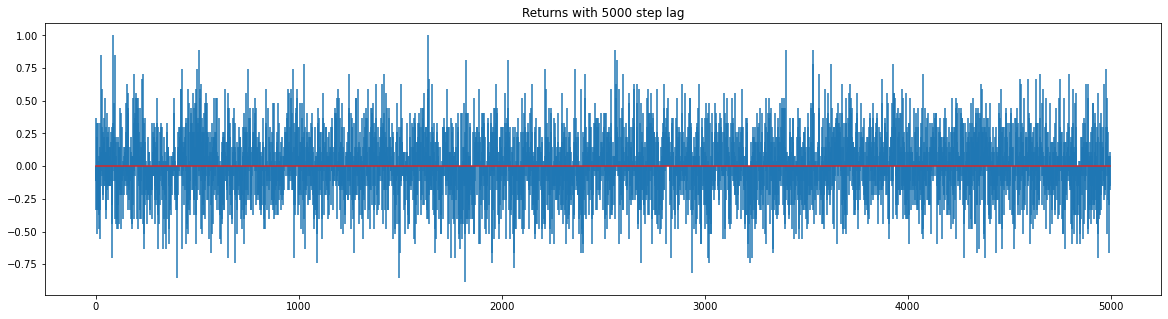

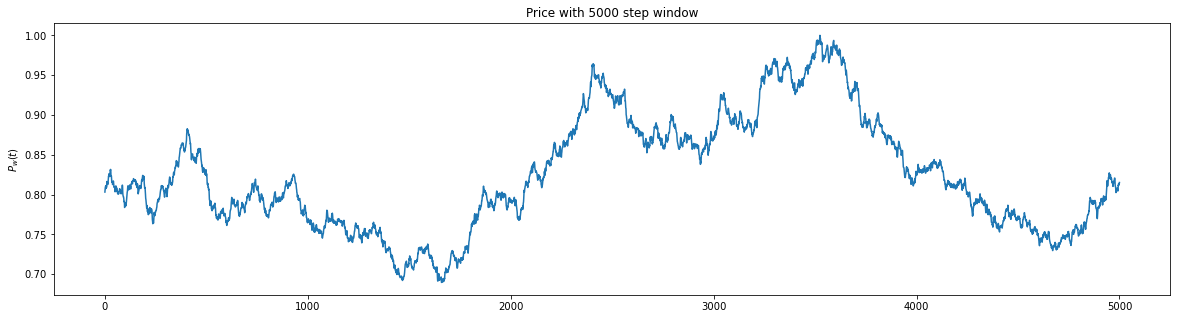

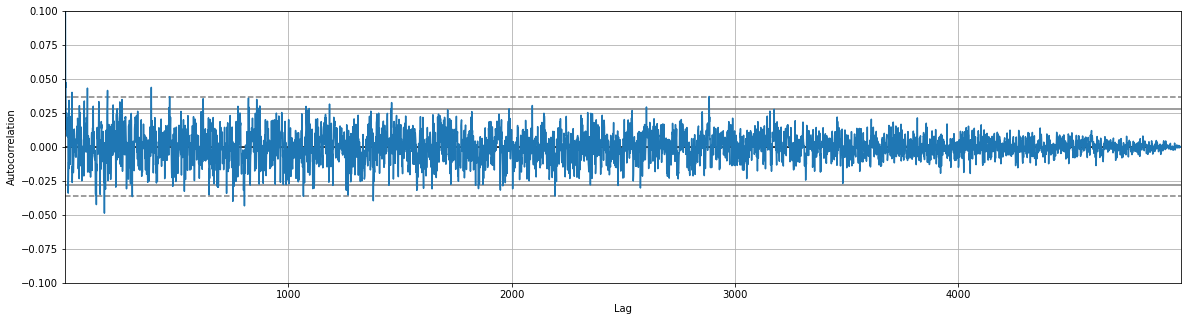

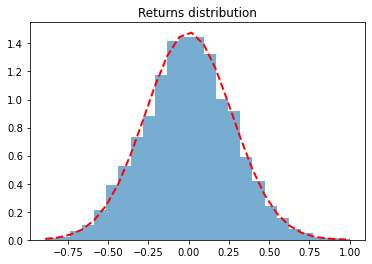

In [452]:
ising.plot(5000, 5000)

All of this is fairly reminiscent of stock returns. In particular, we have achieved what looks to be a log normal return distribution and we also see volatility clustering - an easily recognizable signature of price dynamics. We now compare these results with the empirical results.

In [521]:
import yfinance as yf
import seaborn as sns

def get_returns(symbol="SPY", period="20y"):
    symbol = yf.Ticker(symbol) 
    close_price = symbol.history(period=period).Close
    if not close_price.empty:
        return normalize(np.log(close_price.shift(-1)/close_price))

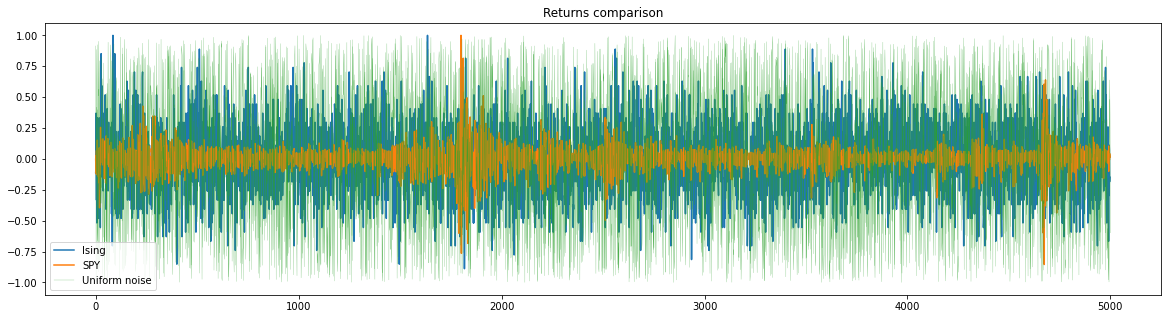

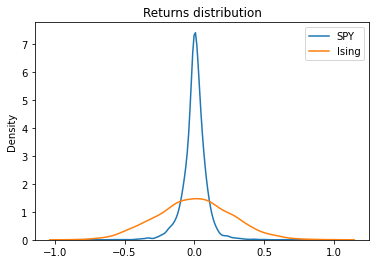

In [550]:
returns = get_returns()[1:5000].values
plt.figure(figsize=(20,5))
plt.title("Returns comparison")
plt.plot(ising.returns[:5000], label="Ising")
plt.plot(returns, label="SPY")
plt.plot((rand(5000)-1/2)*2,linewidth=0.2 , label="Uniform noise")
plt.legend();
plt.figure()
plt.title("Returns distribution")
sns.kdeplot(returns, label="SPY")
sns.kdeplot(ising.returns[1:5000], label="Ising")
plt.legend();

The return distributions are rather different but I have made no effort to tune the model. While we do see volatility clustering in the Ising model, SPY has significantly more dramatic fluctuations around 2008 and 2020. To be a bit more rigorous in our comparison, we can also take a look at the autocorrelations of both returns:

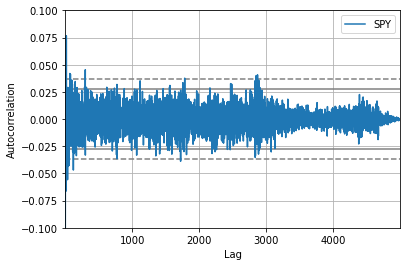

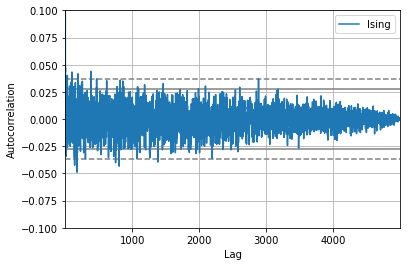

In [557]:
plt.figure()
pd.plotting.autocorrelation_plot(returns, label="SPY")
plt.ylim(-0.1, 0.1)
plt.legend()
plt.figure()
pd.plotting.autocorrelation_plot(ising.returns[1:5000], label="Ising")
plt.legend()
plt.ylim(-0.1, 0.1);

Qualitatively similar. I would bet that a scaling (renormalization group) analysis would reveal that they are also quantitatively similar - let's not get into this here though.

## More on market 'temperature' and the lag parameter

I mentioned that we introduce a scale parameter either by using a moving average of magnetization as the $\log$ price process or more intuitively by considering returns over some window. While morally equivalent, the former method is more directly related, in spirit, to what is called the [renormalization group](https://en.wikipedia.org/wiki/Renormalization_group) (actually a very involved nonequilibrium extension). Since we are concerned with the process of equilibration (thermalization as we call it) the techniques that would be required to analyze the scaling behaviour of price dynamics analytically is far beyond my scope. Instead of this more interesting aspect, I will elaborate on an equilibrium version of the problem that will hopefully illuminate the role of the $β$ parameter. 

As a function of $1/T$, the Ising model describes an order-disorder transition. As such it can serve as a model for freezing and melting (lattice to no lattice) as it can for magnetization and demagnetization above the Curie temperature among many other things. We do not want to model markets as ordered systems because a global consensus position would result in either $P_t \nearrow\infty$ or $ P_t\searrow 0$ neither of which is very conceptually useful.

If the ordered phase is undesirable and the disordered phase is, what about the transition? Physically, two dimensional criticality is arguably the point at which any physical model is most interesting (especially in dimension 2). We first determine the magnetization as a function of $\beta$ to find the critical inverse temperature. Before each Monte Carlo loop per temperature increment we are going to have to take some unrecorded Monte Carlo steps to let the system thermalize to the new temperature.

In [525]:
ising_sweep = MC_ising(20, n_samples=1000, h=1.5)
ising_sweep.run(np.linspace(1.5, 0.05, 100),  n_therm=100)

Running MC on 20x20 square lattice
Number of time/temperature steps:  100
Number of MC samples:  1000
Thermalization steps:  100
J:  1 /kB
h:  1.5 /kB


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [16:20<00:00,  9.80s/it]


Critical 1/T:  0.4601


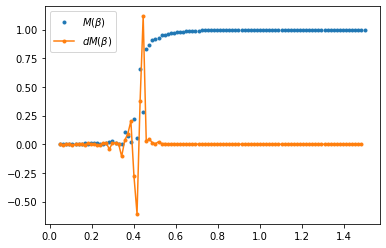

In [532]:
plt.plot(ising_sweep.beta, np.abs(ising_sweep.magnetizations), '.', label=r"$M(\beta)$")
plt.plot(ising_sweep.beta[1:], np.diff(ising_sweep.magnetizations), '.-', label=r"$dM(\beta)$")
plt.legend()

print("Critical 1/T: ", round(ising_sweep.beta[np.argmax(np.diff(ising_sweep.magnetizations))], 4))

The magnetization as a function of $\beta$ clearly indicates that up until $\beta\sim 0.5$ there is no ordered alignment of trade decisions. In equilibrium, this phase could be understood as the asset trading at the market clearing price. 

The two dimensional *critical* Ising model is of tremendous physical (and mathematical) interest though I'm not sure if it is relevant to us. The methods I employ here are ill equipped to probe critical systems for various reasons I won't get into, though I suspect the Ising model is best adapted to a financial market near criticality.

# Potts model and various generalizations

Mapping the behavior of traders onto the Ising model asserts that they buy and sell at any given time step. Over the large number of Monte Carlo samples that we need, this produces a great deal of what we consider to be noise because, realistically, not every trader places a trade at any given time step. What is more realistic, of course, is allowing the agents to hold over an extended period of time or even to close their position and never open another one. 

On the physics side of things, a three state version of the Ising model is known as the Potts model. The generalization it provides is rather esoteric - it allows for parastatistical degrees of freedom (neither Bosonic nor Fermionic). Without going into the mathematical physics of things, one might expect some long range behavior with interesting financial implications to emerge due to the fractional spin (encoded by branch cuts in correlators) - though I have actually done some work indicating that this is not the case.

I will implement the three state Potts model rather naively in that I will compute the energy difference of a spin flip by brute fore - there are much slicker ways of doing this. The generalized cost functional is

$$
\mathcal C = \sum_{\langle ij\rangle} J_{\tau_i\tau_j} \tau_i\tau_j - h\sum_{i}|M(t)|\tau_i, \; \tau_i\in\{-1, 0, 1\}.
$$
I've also introduced a state dependent $J_{\tau_i\tau_j}$ which is a generalization that is rather unpalatable to a physicist but helps tell a more realistic story in our case (of course we could have done this in with the two-state Ising model as well). We know that in a real market a traders likelihood to buy, hold or sell is not uniform. For instance, retail traders, on any given time step, are far likelier to hold while market makers will not be doing much holding.

In [529]:
class MC_potts(MC_ising):
    def __init__(self, N, q=3, J=[1,1,1], h=1, n_samples=500):
        self.state = randint(3, size=(N, N))-1
        assert q==3 # don't really need further generalization for now
        self.n = len(self.state)
        self.N = N
        self.mag = self.state.sum()
        self.J = J
        self.n_samples = n_samples
        self.h = h
        self.q = q
        
    def energy(self, *arg_state):
        en = 0
        if len(arg_state)==0:
            state = self.state
        else:
            state = arg_state[0]
        for i in range(0, self.n):
            for j in range(0, self.n):
                if state[i, j] == -1:
                    J_ = self.J[0]
                elif state[i, j] == 0:
                    J_ = self.J[1]
                else:
                    J_ = self.J[2]
                en -= (1/4)*self.nn(i, j)*state[i , j]*J_ # Bond 
                en -= state[i, j]*self.h # On-site
        return en
        
    def step(self, beta_idx):
        f_names = []
        self.mag = self.state.sum()
        self.total_energy = self.energy(self.state)
        for i in range(0, self.n):
            for j in range(0, self.n):
                state_MC = self.state
                x, y = randint(0, self.N), randint(0, self.N)
                #dE = 2*self.state[x, y]*self.nn(x, y)+2*self.state[x, y]*self.h*abs(self.mag)/(self.N**2*self.n_samples)
                spin = self.state[x, y]
                states = list(range(-int(self.q/2), 1+int(self.q/2)))#.remove(spin)
                states.remove(spin)
                state_MC[x, y] = np.random.choice(states)
                _energy = self.energy(state_MC)
                dE = _energy - self.total_energy
                if dE < 0 or rand()<np.exp(-self.beta[beta_idx]*dE):
                    self.state[x, y] = state_MC[x, y]
                    self.total_energy = _energy
                else:
                    self.total_energy = self.energy(self.state)
        self.mag = self.state.sum()

In [530]:
potts = MC_potts(20, n_samples=1000, h=2, J=[.2, 5, .2])
potts.run([.35],  n_therm=1, save_states=True, gif_name="MC_steps_potts.gif")

Running MC on 20x20 square lattice
Inverse temperature:  0.35
Number of MC samples:  1000
Thermalization steps:  1
J:  [0.2, 5, 0.2] /kB
h:  2 /kB


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [9:07:22<00:00, 32.84s/it]


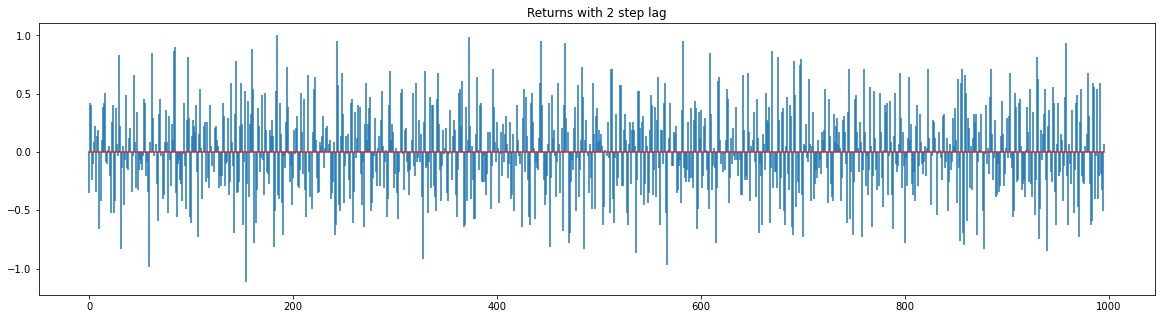

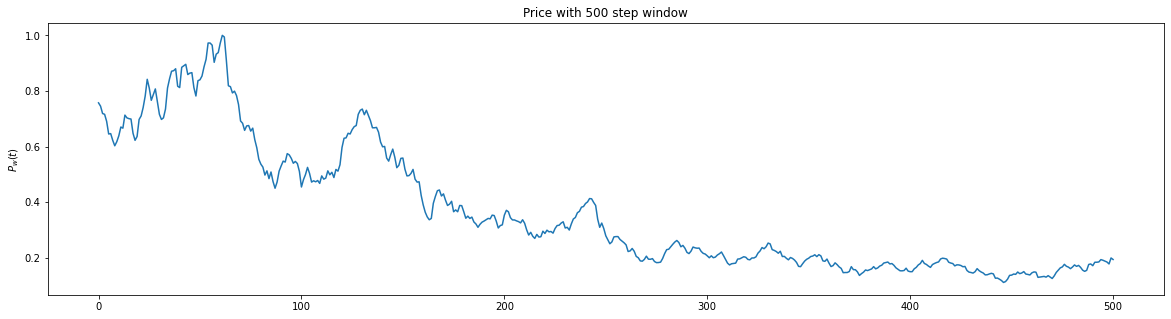

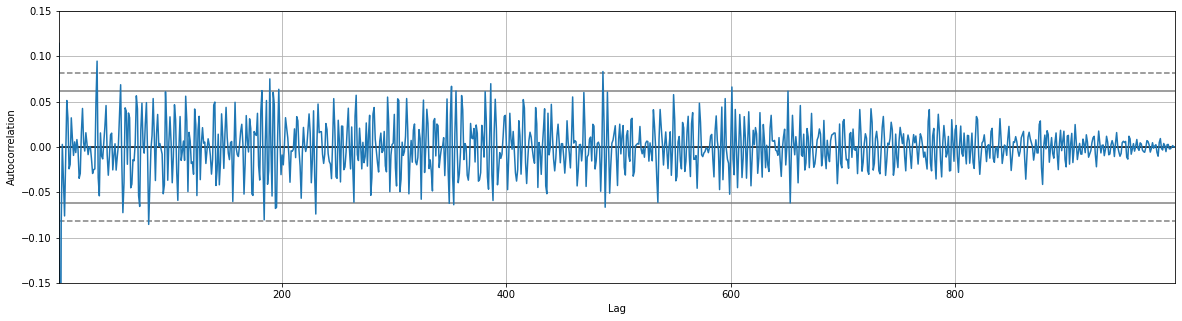

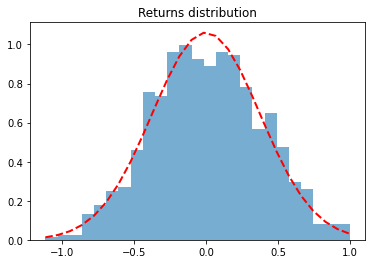

In [531]:
potts.plot(2, 500)

Notice the islands of holders (yellow) that emerge when we dampen the propensity to place a trade:

![test](0.35_MC_steps_potts.gif)

## A model of irrationality and strategy

We can go further in our generalization and let the coupling of traders be a functional of the current market sentiment, $J_{\tau_i\tau_j}[M(t)]$, to model all sorts of behavioral effects. Consider the following example

$$
J_{\tau_i\tau_j}[M(t)]= \left\{
        \begin{array}{ll}
            J_{buy}≥ J_{hold}≥ J_{sell} & \quad M(t)-M(t-w) \geq \sigma_\uparrow \\
           J_{buy}\leq J_{hold}\leq J_{sell} & \quad M(t)-M(t-w) \leq \sigma_\downarrow\\
           J_{buy}=J_{hold}=J_{sell} & \quad \text{else}
        \end{array}
    \right.
$$
where an increase in returns beyond some threshold is met with an increased propensity to buy and likewise a decrease in returns beyond a threshold is met with an increased propensity to sell. The former could be understood as modeling the fear of missing out while the latter as modeling panic selling. 

Similarly we can imagine $h |M(t)|$ to generalize to $h_{\tau_i}[|M(t)|]$ translating to savvy contrarian traders implementing their own strategies based on the information available. The corresponding example here would be a propensity to trade with exit strategies. 

To implement these extensions we return to the two state Ising model (because my Potts implementation is too slow)


In [470]:
def last_nonzero(arr, axis=0, invalid_val=0):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmin(axis=axis), invalid_val)

class MC_ising_extended(MC_ising):
    def __init__(self, N, J0=1, J=[1.4,1.2], h=1, n_samples=500, w=20, lattice=False, bound=[1, -1]):
        super().__init__(N, J=J, h=h, n_samples=n_samples)
        if lattice:
            self.lattice = lattice
        else:
            self.lattice = np.ones([N, N])
        self.w = w
        self.step_idx = 0
        self.bound = bound
        self.J = J
        self.J0 = J0
        self.mag_diff = 0

            
    def step(self, beta_idx):
        self.mag = self.state.sum()
        if self.step_idx%self.w == 0:
            self.mag_ = self.mag
        self.step_idx += 1
        for i in range(0, self.n):
            for j in range(0, self.n):
                x, y = randint(0, self.N), randint(0, self.N)
                if self.mag_diff > self.bound[0]:
                    if self.state[x, y] == 1:
                        J_ = self.J0*self.J[0]
                    else:
                        J_ = self.J0
                elif self.mag_diff < self.bound[1]:
                    if self.state[x, y] == 1:
                        J_ = self.J0
                    else:
                        J_ = self.J0*self.J[1]
                else:
                    J_ = self.J0
                dE = 2*self.state[x, y]*self.nn(x, y, J_)+2*self.state[x, y]*self.h*abs(self.mag)/(self.N**2*self.n_samples)
                if dE < 0 or rand()<np.exp(-self.beta[beta_idx]*dE):
                    self.state[x, y] *= -1
        self.mag = self.state.sum()
        self.mag_diff = self.mag_/self.mag-1
       
        
    def nn(self, i, j, J_):
        return J_*(self.state[(i+1)%self.N, j]+self.state[(i-1)%self.N, j]+self.state[i, (j+1)%self.N]+self.state[i, (j-1)%self.N])
        
        

In [471]:
extended_ising = MC_ising_extended(20, h=2, w=5, J=[1.2, 1.5], n_samples=2000)
extended_ising.run([0.1])

Running MC on 20x20 square lattice
Inverse temperature:  0.1
Number of MC samples:  2000
Thermalization steps:  1
J:  [1.2, 1.5] /kB
h:  2 /kB


  0%|▍                                                                               | 10/2000 [00:00<00:20, 98.04it/s]<ipython-input-470-c11e28ec8d3e>:44: RuntimeWarning: divide by zero encountered in long_scalars
  self.mag_diff = self.mag_/self.mag-1
 53%|████████████████████████████████████████▍                                    | 1051/2000 [00:08<00:08, 118.13it/s]<ipython-input-470-c11e28ec8d3e>:44: RuntimeWarning: invalid value encountered in long_scalars
  self.mag_diff = self.mag_/self.mag-1
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 121.44it/s]


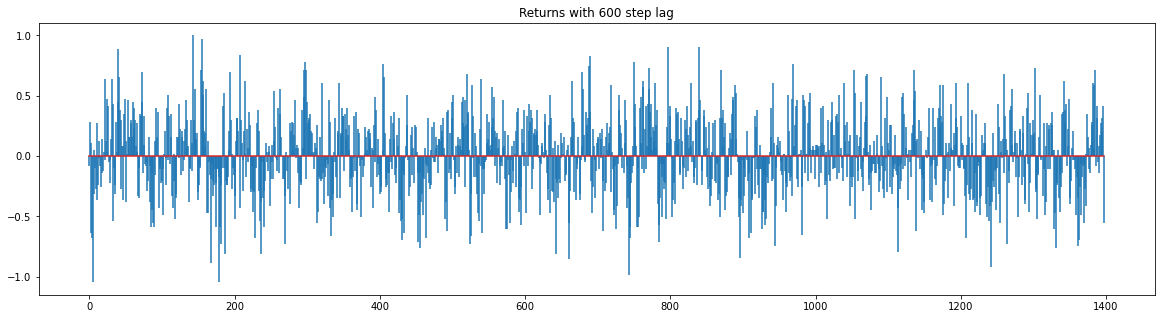

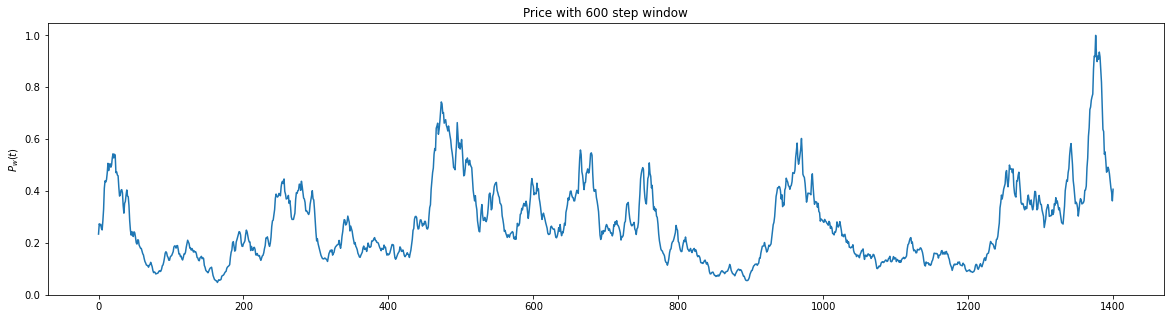

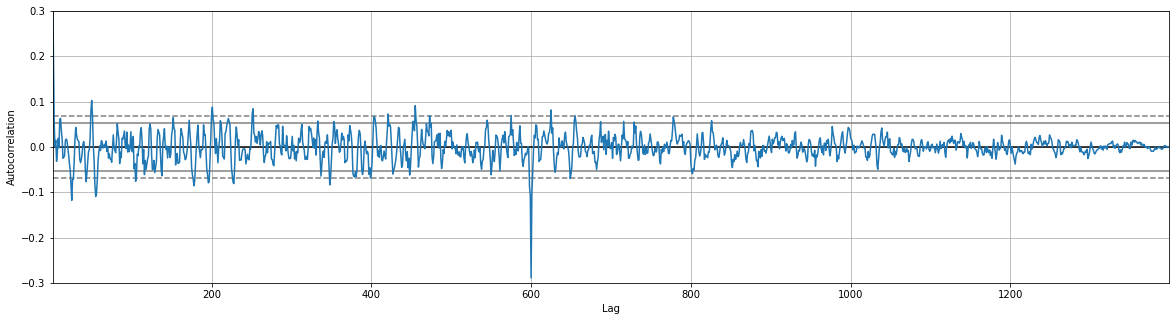

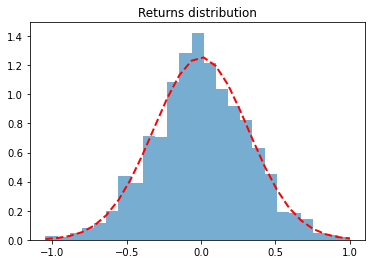

In [472]:
extended_ising.plot(600, 600, y_lims=(-0.3, 0.3))

Different coupling and onsite functionals can be implemented by subclassing the vanilla Ising class. What we have above, specifically, is 

$$
J_{s_i s_j}[M(t)]= \left\{
        \begin{array}{ll}
            uJ_0 & \quad M(t)-M(t-w) \geq \sigma_\uparrow \\
           dJ_0 & \quad M(t)-M(t-w) \leq \sigma_\downarrow\\
           J_0 & \quad \text{else}
        \end{array}
    \right\}
$$
for $J_0,u,d>0$.


When we implement overbuying and overselling behavior we see much stronger autocorrelations in the returns and more clusters of high volatility. What is not clear from the simulation above is that we can actually modify the statistics of the return sequence. To make this apparent we can choose more dramatic scales. With exaggerated $u$ and $d$ factors we are essentially forcing large fluctuations to dominate the dynamics (potentially interpreted as modeling bubbles)

In [473]:
extended_ising_ = MC_ising_extended(20, h=2, w=5, J=[2.2, 4.5], n_samples=2000)
extended_ising_.run([0.1])


Running MC on 20x20 square lattice
Inverse temperature:  0.1
Number of MC samples:  2000
Thermalization steps:  1
J:  [2.2, 4.5] /kB
h:  2 /kB


  1%|▊                                                                              | 22/2000 [00:00<00:18, 106.59it/s]<ipython-input-470-c11e28ec8d3e>:44: RuntimeWarning: divide by zero encountered in long_scalars
  self.mag_diff = self.mag_/self.mag-1
 52%|████████████████████████████████████████▍                                     | 1038/2000 [00:09<00:09, 97.81it/s]<ipython-input-470-c11e28ec8d3e>:44: RuntimeWarning: invalid value encountered in long_scalars
  self.mag_diff = self.mag_/self.mag-1
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 110.45it/s]


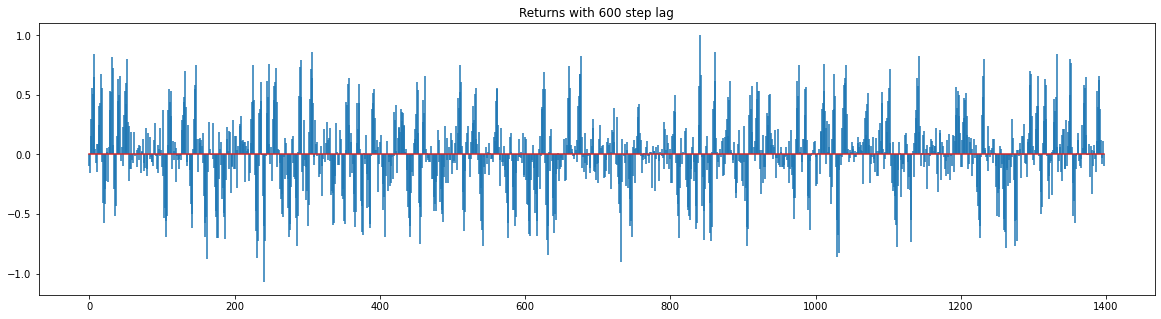

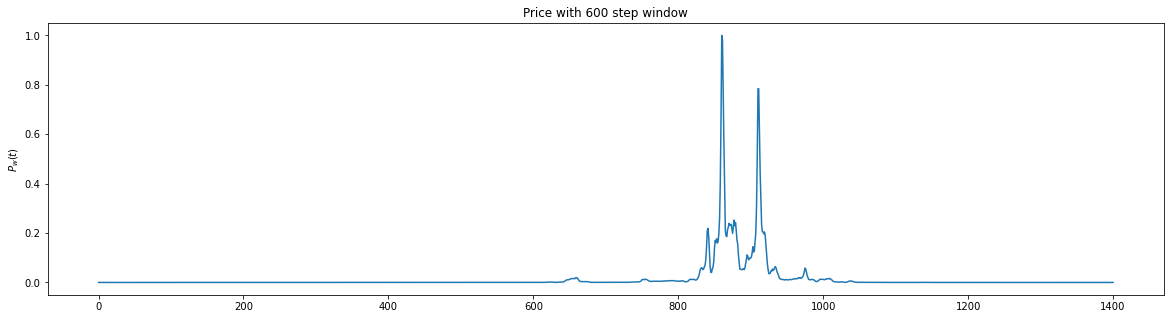

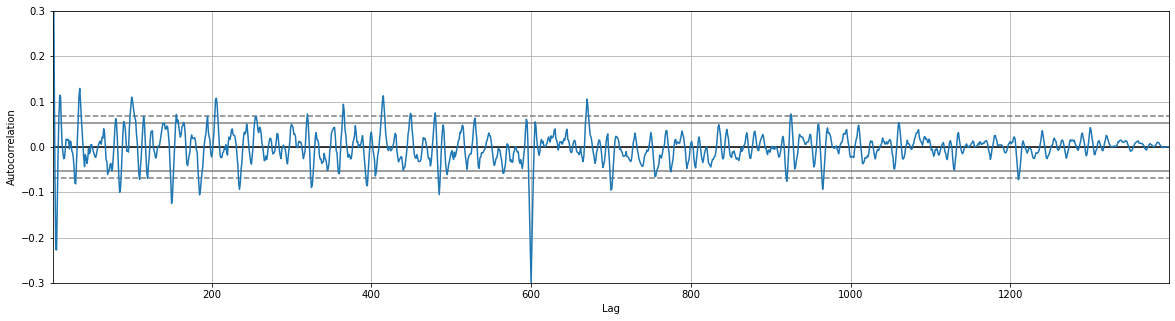

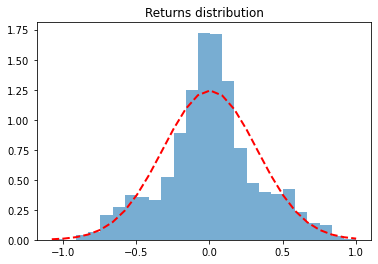

In [474]:
extended_ising_.plot(600, 600, y_lims=(-0.3, 0.3))

Clearly, the return distribution is far from being normal. 

## Taking things even further

Though more complexity is not necessarily better, I will close with a very general Ising-like model:
$$
\mathcal C[\tau]=-\sum_{\mathcal P,\mathcal P'⊂ \Lambda}\left\{\sum_{i,j ∈ \mathcal P} \frac{\tau_{i}\tau_j J_{\tau_i\tau_j}[M(t)]}{|i-j|^{\gamma}}+\sum_{i∈ \mathcal P,j\in \mathcal P'} \frac{\tau_{i}\tau_j J_{\tau_i\tau_j}[M(t)]}{|i-j|^{\gamma'}}+\sum_{i∈ \mathcal P}h_{\tau_i}[M(t)]\tau_i\right\}
$$
There are a couple new things happening here:

- We take a partition of the graph $\Lambda$ with each partition having their own state-dependent coupling functionals, $J[M(t)]$ and $h[M(t)]$. A simple partitioning could be $\mathcal P_{market-makers}\cup \mathcal P^c_{market-makers}$.
- We allow for long range interactions governed by a power law decay parameterized by $\gamma\in[0,\infty)$
- The coupling functionals can be random. This can gives rise to very complex nonequilibrium phases, regardless of temperature. 

To my knowledge, many of these are not explored. 

**TLDR - the price of a security is an emergent property of an interacting system of traders and can be described without any reference to a filtration information to which it is adapted.**